In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mydata/inaturalist_12K/val/Reptilia/8f68c5f58315870b69f35bccbba75a37.jpg
/kaggle/input/mydata/inaturalist_12K/val/Reptilia/d1dea41a26a300cad47a745d113c6af8.jpg
/kaggle/input/mydata/inaturalist_12K/val/Reptilia/a496cceb6fe3784983a8d8e59c30f1e6.jpg
/kaggle/input/mydata/inaturalist_12K/val/Reptilia/402bb3c00f9f397ee9f83ed9191e0d71.jpg
/kaggle/input/mydata/inaturalist_12K/val/Reptilia/66f921bfe3df519cd3a6b6e3923ca647.jpg
/kaggle/input/mydata/inaturalist_12K/val/Reptilia/458ca16be6a45fec3eb04d94a551cb7e.jpg
/kaggle/input/mydata/inaturalist_12K/val/Reptilia/ee6c9d203a79b6009fc9f3abb8bb01e4.jpg
/kaggle/input/mydata/inaturalist_12K/val/Reptilia/a78fe1dfd176763846a6132ba2ccb947.jpg
/kaggle/input/mydata/inaturalist_12K/val/Reptilia/712ceb021f7c5df799dd81a8d86dc191.jpg
/kaggle/input/mydata/inaturalist_12K/val/Reptilia/c136b37eed62112c4cdbb5df50dc8e3d.jpg
/kaggle/input/mydata/inaturalist_12K/val/Reptilia/e943e2e4a14e723ae5039487b097aca1.jpg
/kaggle/input/mydata/inaturalist_12K/val/Re

# Step 1 : Setting up wandb

In [10]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

In [11]:
import wandb
wandb.login(key=secret_value_0)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Step 2: Loading the inaturalist dataset
# train set is divided into train and validation in the ratio 80-20

In [12]:
train = '/kaggle/input/mydata/inaturalist_12K/train'

test = '/kaggle/input/mydata/inaturalist_12K/val'

In [13]:
classes = ['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

# Step 3 : Importing the important libraries

In [1]:
import torch     # core package
import torch.nn as nn    # to build neural network 
import torch.optim as optim  # contains optimisers
#import pytorch_lightning as pl # manage devices 
import torch.nn.functional as F
import wandb
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
import random

# Step 4 : Building a CNN network (same as in part a train)

In [7]:
# function to compute image size after convolution
def compute_img_size(img_w, filter_size, padding, stride):
    return (1 + (img_w - filter_size + (2 * padding)) / stride)

In [8]:
# Reference: https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/

class AdaptiveCNN(nn.Module):
    def __init__(self, input_size=224, input_channels=3, batch_size=64,num_filters=32, filter_org='same', kernel_size=[3]*5, act_fn='relu',num_neurons=256, batch_norm=True, dropout_rate=0.3,
                 learning_rate=1e-3, l2_reg=0.0):
        
        super(AdaptiveCNN, self).__init__()

        # hyperparameters
        self.batch_norm = batch_norm
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg
        self.batch_size = batch_size

        # Set number of filters based on organization type
        if filter_org == 'same':   # keeping all the filters same
            filters = [num_filters] * 5
            
        elif filter_org == 'double': # doubling the filter size 
            filters = [num_filters, num_filters * 2, num_filters * 4, num_filters * 8, num_filters * 16]
        
        elif filter_org == 'half':  # halfing the filter size 
            filters = [num_filters, max(num_filters // 2, 1), max(num_filters // 4, 1), max(num_filters // 8, 1), max(num_filters // 16, 1)]
        
        else:
            raise ValueError("Invalid filter_org")

         # Mapping string for activation function
        act_func = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'gelu': nn.GELU(), 'silu': nn.SiLU(), 'mish': nn.Mish()}
        activation = act_func[act_fn]

         # padding to keep output size constant (same padding)
        padding_vals = [k // 2 for k in kernel_size]

        # 5 convolutional blocks (using Sequential)
        # Every block: Conv2d → (Optional BatchNorm) → Activation → Dropout → MaxPool
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, filters[0], kernel_size=kernel_size[0], padding=padding_vals[0]),
            nn.BatchNorm2d(filters[0]) if batch_norm else nn.Identity(),
            activation,
            nn.Dropout(p=dropout_rate),
            nn.MaxPool2d(2),

            nn.Conv2d(filters[0], filters[1], kernel_size=kernel_size[1], padding=padding_vals[1]),
            nn.BatchNorm2d(filters[1]) if batch_norm else nn.Identity(),
            activation,
            nn.Dropout(p=dropout_rate),
            nn.MaxPool2d(2),

            nn.Conv2d(filters[1], filters[2], kernel_size=kernel_size[2], padding=padding_vals[2]),
            nn.BatchNorm2d(filters[2]) if batch_norm else nn.Identity(),
            activation,
            nn.Dropout(p=dropout_rate),
            nn.MaxPool2d(2),

            nn.Conv2d(filters[2], filters[3], kernel_size=kernel_size[3], padding=padding_vals[3]),
            nn.BatchNorm2d(filters[3]) if batch_norm else nn.Identity(),
            activation,
            nn.Dropout(p=dropout_rate),
            nn.MaxPool2d(2),

            nn.Conv2d(filters[3], filters[4], kernel_size=kernel_size[4], padding=padding_vals[4]),
            nn.BatchNorm2d(filters[4]) if batch_norm else nn.Identity(),
            activation,
            nn.Dropout(p=dropout_rate),
            nn.MaxPool2d(2),
        )


        
        size = input_size
        for i in range(5):
            size = compute_img_size(size, kernel_size[i], padding_vals[i], 1)
            size = size // 2 # for pooling

         # Defining fully connected layers
        self.flattened_size = int(size * size * filters[4])

        self.fc_layers = nn.Sequential(
            
            nn.Flatten(),           # flattening of 3D tensor to 1D
            nn.Linear(self.flattened_size, num_neurons),
            activation,              # Activation function
            nn.Dropout(p=dropout_rate),   # Dropout (as regularization)
            nn.Linear(num_neurons, 10)    # Final output layer (for 10 classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Forward pass through conv blocks
        x = self.fc_layers(x)     # Forward pass through fully connected blocks
        return x


# Step 5 : Data Loaders (test)

In [3]:
def test_data_load(data_dir, use_aug):
    
    # Define standard transforms 
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),   # Resize to 224x224
        transforms.ToTensor(),             # Convert image to PyTorch tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))     # Normalize to [-1, 1] range with mean and std of 0.5 for each channel
    ])

        # Load the test dataset using ImageFolder from 'val/' directory
    return datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)


# Step 6 : Loads and preprocesses the training dataset 

In [4]:

def data_load(data_dir, use_aug):
    base_transforms = [
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),   # Convert images to PyTorch tensors
         # Normalize images to [-1, 1] range using mean=0.5 and std=0.5 for all channels
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ]
    
    augment = [transforms.RandomHorizontalFlip(), transforms.RandomRotation(10)]
    transform = transforms.Compose(augment + base_transforms) if use_aug else transforms.Compose(base_transforms)

    # Load the full dataset using ImageFolder
    full_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
    return stratified_split(full_dataset)

# Step 7 : Splitting the dataset

In [9]:
# Stratified split to ensure that each class is equally represented
def stratified_split(dataset, val_fraction=0.2, seed=42):
    
    random.seed(seed)   # Set seed for reproducibility
    
    # Create a dictionary mapping each class label to a list of its sample indices
    label_to_indices = defaultdict(list)

    
    for idx, (_, label) in enumerate(dataset.samples):
        label_to_indices[label].append(idx)

    train_indices, val_indices = [], []
    
    for label, indices in label_to_indices.items():
        n_val = int(len(indices) * val_fraction)
        random.shuffle(indices)
        val_indices.extend(indices[:n_val])
        train_indices.extend(indices[n_val:])
        
    return Subset(dataset, train_indices), Subset(dataset, val_indices)     # Return Subset objects to be used with DataLoader

# Step 8 : Visualisation function

In [10]:
def img_plot(model, test_loader):
    classes = test_loader.dataset.classes
    class_images = {cls: [] for cls in range(10)}
    for x, y in test_loader:
        for img, label in zip(x, y):
            if len(class_images[label.item()]) < 3:
                class_images[label.item()].append(img)
        if all(len(imgs) == 3 for imgs in class_images.values()):
            break

    model.eval()
    fig, axes = plt.subplots(10, 3, figsize=(12, 20))
    for i in range(10):
        for j in range(3):
            img = class_images[i][j].unsqueeze(0).cuda()
            with torch.no_grad():
                pred = torch.argmax(model(img), dim=1).item()
            npimg = img.squeeze(0).cpu().permute(1, 2, 0).numpy()
            axes[i][j].imshow((npimg * 0.5 + 0.5).clip(0, 1))
            axes[i][j].axis('off')
            axes[i][j].set_title(f"True: {classes[i]}\nPred: {classes[pred]}")
    plt.tight_layout()
    wandb.log({"10x3 Predictions Grid": wandb.Image(fig)})
    plt.show()

# Step 9 : Main Training, Validation, and Testing Pipeline

In [6]:
def model_train_val_and_test(model, train_data, val_data, test_data, epochs):
    
    # Initialize wandb run with best config
    wandb.init(project="DL_assignment_2_eval", config=best_config)
    config = wandb.config

    
    # Optimizer 
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.l2_reg)

    
    # Cross Entropy Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Data loaders
    train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False)

    # Training + Validation Loop
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0

              # Training pass
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # validation
        model.eval()
        val_correct, val_total, val_loss_total = 0, 0, 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item() * x.size(0)
                _, pred = torch.max(out, 1)
                val_correct += (pred == y).sum().item()
                val_total += y.size(0)

        val_loss = val_loss_total / val_total
        val_acc = val_correct / val_total

        
        # Print & log metrics
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    # Final TEST evaluation 
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = torch.max(out, 1)
            test_correct += (pred == y).sum().item()
            test_total += y.size(0)

    test_acc = test_correct / test_total
    print(f"\n Final Test Accuracy: {test_acc * 100:.2f}%")
    wandb.log({'test_accuracy': test_acc})

    # Visualization
    img_plot(model, test_loader)

# Step 10 :  Main function

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch [1/20] - Train Loss: 2.2026, Train Acc: 0.2040 - Val Acc: 0.2161
Epoch [2/20] - Train Loss: 2.0726, Train Acc: 0.2595 - Val Acc: 0.2391
Epoch [3/20] - Train Loss: 2.0180, Train Acc: 0.2845 - Val Acc: 0.2881
Epoch [4/20] - Train Loss: 1.9956, Train Acc: 0.2919 - Val Acc: 0.2876
Epoch [5/20] - Train Loss: 1.9676, Train Acc: 0.2974 - Val Acc: 0.2916
Epoch [6/20] - Train Loss: 1.9472, Train Acc: 0.3071 - Val Acc: 0.2706
Epoch [7/20] - Train Loss: 1.9175, Train Acc: 0.3166 - Val Acc: 0.3102
Epoch [8/20] - Train Loss: 1.8989, Train Acc: 0.3251 - Val Acc: 0.2796
Epoch [9/20] - Train Loss: 1.8884, Train Acc: 0.3255 - Val Acc: 0.2796
Epoch [10/20] - Train Loss: 1.8696, Train Acc: 0.3340 - Val Acc: 0.3142
Epoch [11/20] - Train Loss: 1.8633, Train Acc: 0.3326 - Val Acc: 0.2661
Epoch [12/20] - Train Loss: 1.8604, Train Acc: 0.3366 - Val Acc: 0.2566
Epoch [13/20] - Train Loss: 1.8517, Train Acc: 0.3380 - Val Acc: 0.2946
Epoch [14/20] - Train Loss: 1.8172, Train Acc: 0.3488 - Val Acc: 0.2786
E

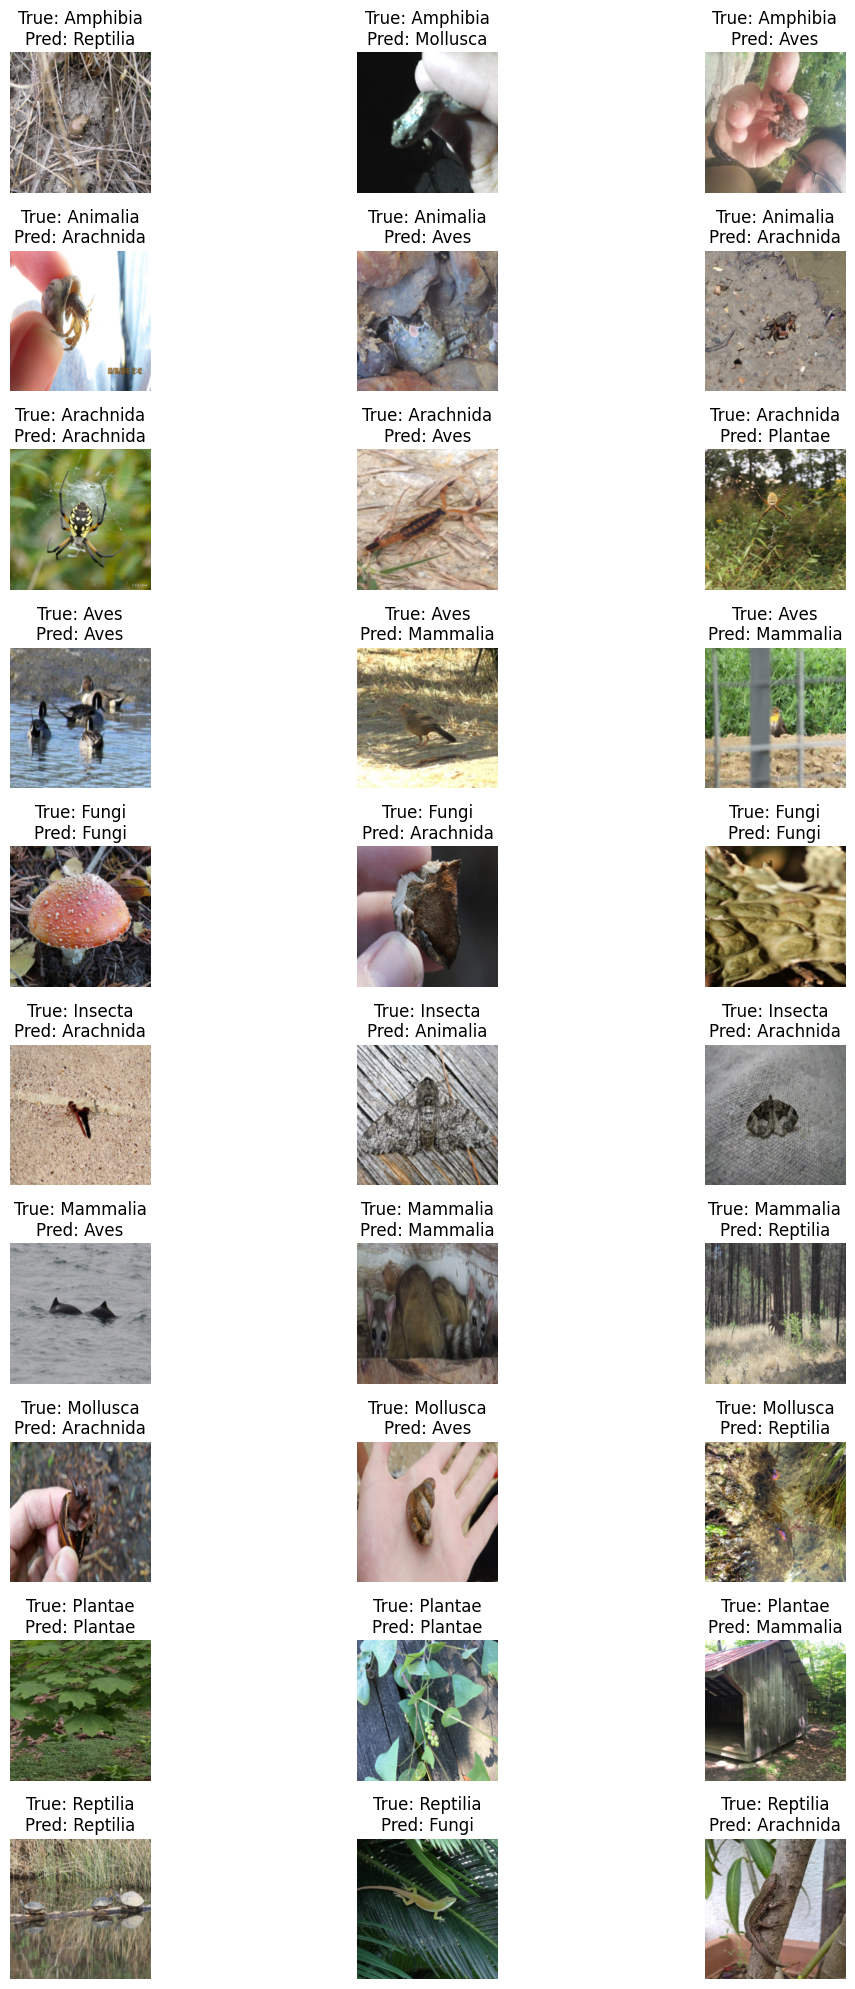

In [ ]:
  
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AdaptiveCNN(
        input_size=224,
        input_channels=3,
        batch_size=best_config['batch_size'],
        num_filters=best_config['num_filters'],
        filter_org=best_config['filter_org'],
        kernel_size=best_config['kernel_size'],
        act_fn=best_config['act_fn'],
        num_neurons=best_config['num_neurons'],
        batch_norm=best_config['batch_norm'],
        dropout_rate=best_config['dropout_rate'],
        learning_rate=best_config['learning_rate'],
        l2_reg=best_config['l2_reg']
    ).to(device)

    # Load both train and validation splits from /train
    train_data, val_data = data_load("/kaggle/input/mydata/inaturalist_12K/", best_config['data_augmentation'])

    test_data = test_data_load("/kaggle/input/mydata/inaturalist_12K/", best_config['data_augmentation'])

    model_train_val_and_test(model, train_data, val_data, test_data, best_config['epochs'])